In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [3]:
import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2

# Denoising SET1~10 image with FBI-denoiser


## Load original img
with 0~1 scale

In [4]:
"""
img_dict = {}
debug = False
# data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
for data_path in glob("/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung*SNU*"):
    for set_num in sorted(os.listdir(data_path)):
        if set_num[0] == '.' :
            continue
        img_dict[set_num] = {}
        # if debug is True:
        #     print(set_num)
        set_path = os.path.join(data_path,set_num)
        img_list = sorted(os.listdir(set_path))
        img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
        f_num_list = np.array(list(map(lambda x : x.split('_')[0],img_list)))
        f_num_list = np.unique(f_num_list)
        for f_num in f_num_list:
            img_dict[set_num][f_num] = None
        # if debug is True:
        #     print(img_list)
        #     print(f_num_list)


        for img_path in sorted(img_list):
            f_num = img_path.split("_")[0]

            img_path = os.path.join(set_path,img_path)
            if debug is True:
                print(f_num," & ",img_path)
            img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            # img_dict[set_num][f_num].append(img)
            img = np.expand_dims(img,axis=0)
            img = np.expand_dims(img,axis=0)/255.
            if img_dict[set_num][f_num] is None:  
                img_dict[set_num][f_num] = img
            else :
                img_dict[set_num][f_num] = np.append(img_dict[set_num][f_num],img,axis=0)
            if debug is True:
                print(set_nu,f_num,img.shape)
"""
img_dict = np.load("./intermediate_result/full_img_dict.npy",allow_pickle=True).item()

In [5]:
print(img_dict.keys())
for set_num in img_dict.keys():
    print(img_dict[set_num].keys())
    for f_num in img_dict[set_num].keys():
        print(img_dict[set_num][f_num].shape)

dict_keys(['SET01', 'SET02', 'SET03', 'SET04', 'SET05', 'SET06', 'SET07', 'SET08', 'SET09', 'SET10'])
dict_keys(['F08', 'F16', 'F32', 'F64'])
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
(16, 1, 1474, 3010)
dict_keys(['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64'])
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
dict_keys(['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64'])
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
(2, 1, 1454, 2990)
dict_keys(['F01', 'F02', 'F04'

In [6]:
args = get_args()
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False
args

Namespace(date='', seed=0, noise_type='Poisson-Gaussian', loss_function='MSE_Affine', model_type='FBI_Net', data_type='Grayscale', data_name='Samsung', nepochs=50, batch_size=4, lr=0.001, drop_rate=0.5, drop_epoch=10, crop_size=120, alpha=0.01, beta=0.02, num_layers=17, num_filters=64, mul=1, unet_layer=3, pge_weight_dir=None, output_type='sigmoid', sigmoid_value=0.1, use_other_target=False, x_f_num='F1', y_f_num='F64', integrate_all_set=False, set_num=1, test=False, train_with_MSEAffine=False, debug=False)

In [42]:
debug= True

for fbi_weight_dir in glob("../weights/230207_FBI_Net*"):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    if debug is True:
        print(fbi_weight_dir)
    print("======",target_y,dataset_version,"======")
    folder_name = f"./denoised_img_{target_y}_{dataset_version}"
    os.makedirs(folder_name,exist_ok=True)
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    denoised_img_dict = {}
    for set_num in img_dict.keys():
        denoised_img_dict[set_num] = {}
        for f_num in img_dict[set_num].keys():
            denoised_img_dict[set_num][f_num] = None
            for img in img_dict[set_num][f_num]:
                img = np.expand_dims(img, axis=0) # (1,1,1474,3010)
                print(img.shape,img.min(),img.max())
                denoised_img = model.eval(img)
                if denoised_img_dict[set_num][f_num] is None:
                    denoised_img_dict[set_num][f_num] = denoised_img
                else :
                    denoised_img_dict[set_num][f_num] = np.append(denoised_img_dict[set_num][f_num], denoised_img,axis=0)

            print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            sys.exit(-1)
    # SAVE IMG
    print(denoised_img_dict.keys())
    for set_num in denoised_img_dict.keys():
        print(denoised_img_dict[set_num].keys())
        os.makedirs(f"{folder_name}/{set_num}", exist_ok=True)
        for f_num in denoised_img_dict[set_num].keys():
            # print(denoised_img_dict[set_num][f_num].shape)
            filename = f"{folder_name}/{set_num}/{f_num}.npy"
            np.save(filename, denoised_img_dict[set_num][f_num])
            # for idx,img in enumerate(denoised_img_dict[set_num][f_num]):
            #     filename = f"{folder_name}/{set_num}/{f_num}_{idx:02d}.png"
            #     img = (img*255).astype('uint8')
            #     cv2.imwrite(filename, img[0])
            print(f"Saving SET : {set_num}, f_num : {f_num} End")
    del model,denoised_img_dict
    gc.collect()


../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
====== F08 v2 ======
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
Denoising SET : SET01, f_num : F08 End


SystemExit: -1

(1474, 3010) -1.7194686 245.86078


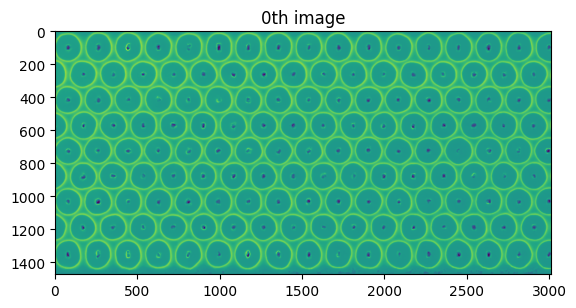

In [43]:
# denoised_img_dict['SET01']['F08'].shape
index = 0
for index in range(16):
    plt.title(f"{index}th image")
    img = denoised_img_dict['SET01']['F08'][index][0] * 255
    # img = (img - img.min())/(img.max()-img.min())
    print(img.shape,img.min(),img.max())
    plt.imshow(img)
    plt.pause(0.01)
    break

0



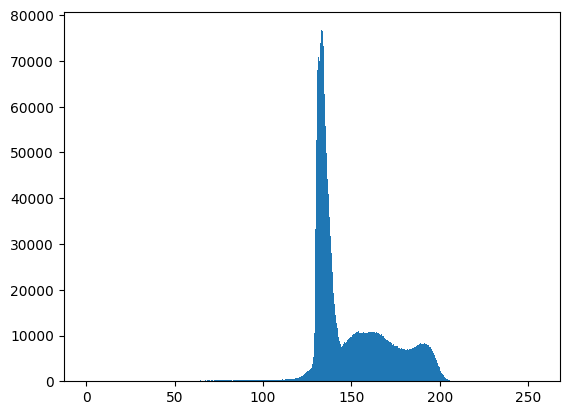

In [50]:
print(index)
bins= np.linspace(0,255,1000)
plt.hist(bins=bins,x=(img).flatten())
print("")

In [53]:
np.max(img),np.argmax(img)

(245.86078, 343576)